In [1]:
import src.data.data_load as data_load
import src.data.processing as processing
import src.data.imputing as imputing
import src.data.feature_engin as feature_engin

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# TASK 1A: EXPLORATORY DATA ANALYSIS

In [2]:
df = data_load.load_mood_dataset("./raw_data/dataset_mood_smartphone.csv")
# fast knowledge of the data
print(df.isnull().mean().sort_values(ascending=False))
print("there are {} rows in the dataset".format(df.shape[0]))
print("there are {} columns in the dataset".format(df.shape[1]))

variable
appCat.weather          0.999290
appCat.game             0.997735
appCat.unknown          0.997384
appCat.finance          0.997384
sms                     0.994991
appCat.utilities        0.993071
appCat.travel           0.992071
call                    0.985404
circumplex.valence      0.984749
circumplex.arousal      0.984448
mood                    0.984320
appCat.office           0.984281
appCat.other            0.978686
appCat.social           0.946660
activity                0.936017
appCat.entertainment    0.924427
appCat.communication    0.793060
appCat.builtin          0.745663
screen                  0.730925
time                    0.000000
id                      0.000000
dtype: float64
there are 358926 rows in the dataset
there are 21 columns in the dataset


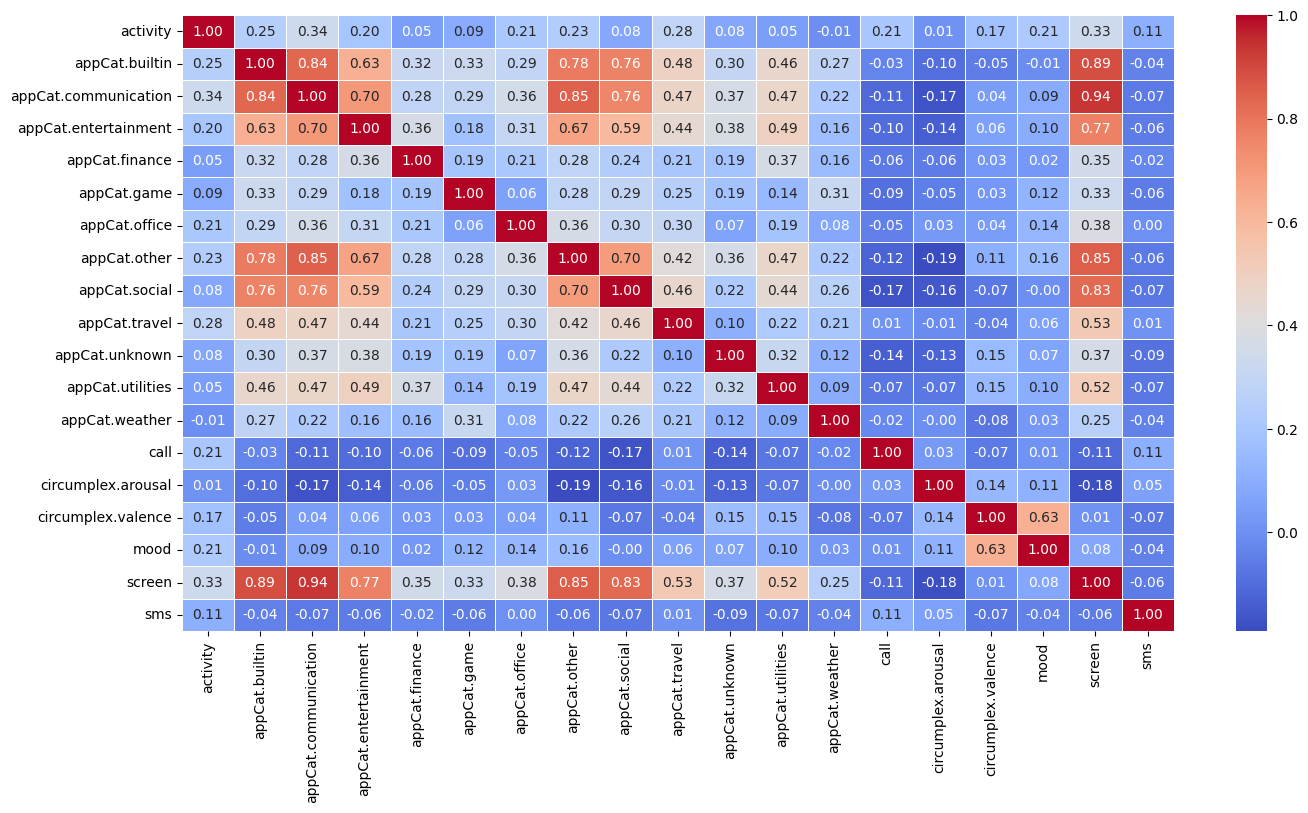

In [3]:
# Step 1: calculate the correlation matrix
filepath = "./raw_data/dataset_mood_smartphone_wide.csv"
df_raw = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)
df_raw['time'] = pd.to_datetime(df_raw['time'])
df_daily = processing.aggregate_by_day(df_raw)
df_daily['date'] = pd.to_datetime(df_daily['date'])  # convert to datetime

numeric_df = df_daily.drop(columns=['id', 'date'])
corr_matrix = numeric_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

removed_features = [
    # over 99.5% missing values
    'appCat.weather',     
    'appCat.game',   
    'appCat.unknown',
    'appCat.finance',

    # correlated features
    'appCat.entertainment',
    'appCat.communication',
    'appCat.other',
    'appCat.social',


    # optional removed
    'appCat.utilities'
    'appCat.travel',
    'SMS',
]


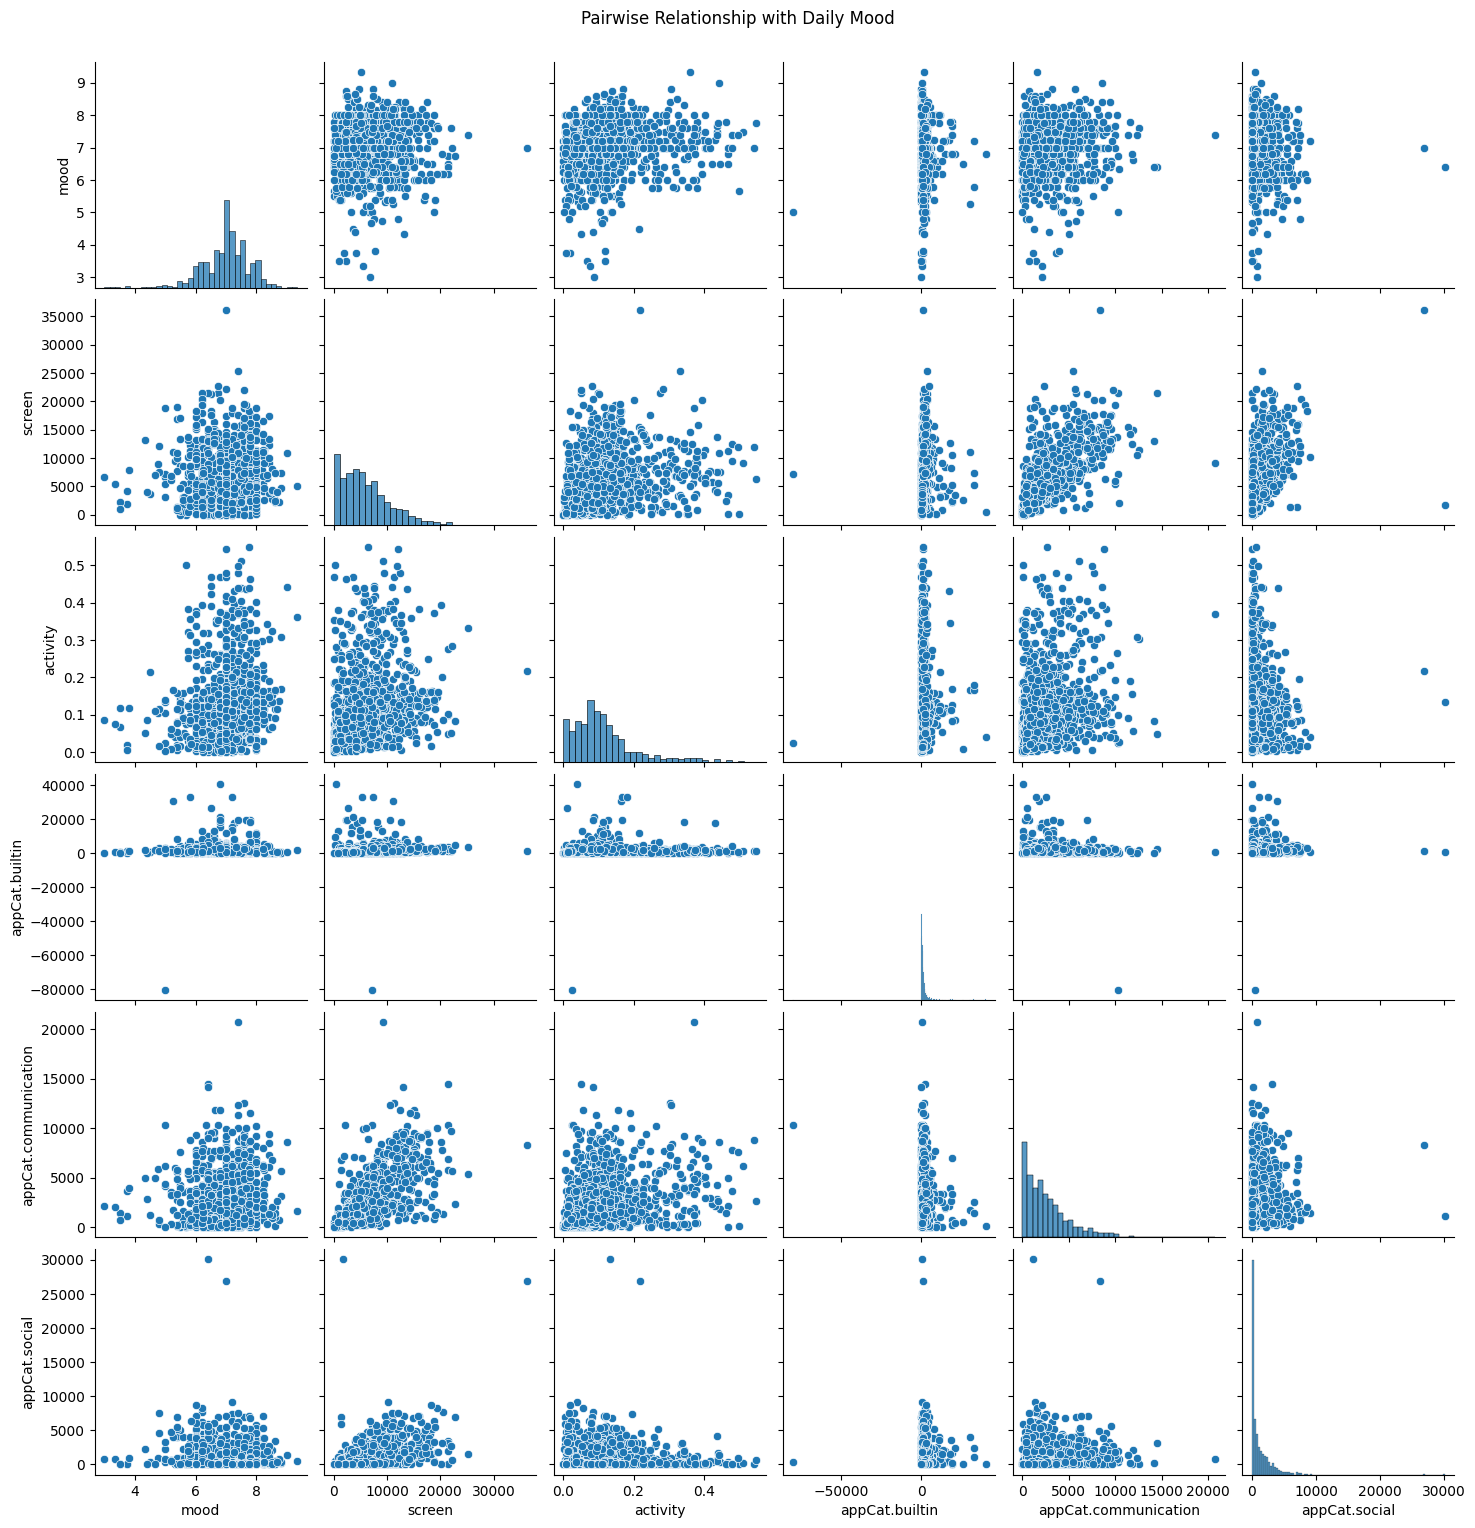

In [4]:
selected = ['mood', 'screen', 'activity', 'appCat.builtin', 'appCat.communication', 'appCat.social']
sns.pairplot(df_daily[selected].dropna())
plt.suptitle("Pairwise Relationship with Daily Mood", y=1.02)
plt.show()

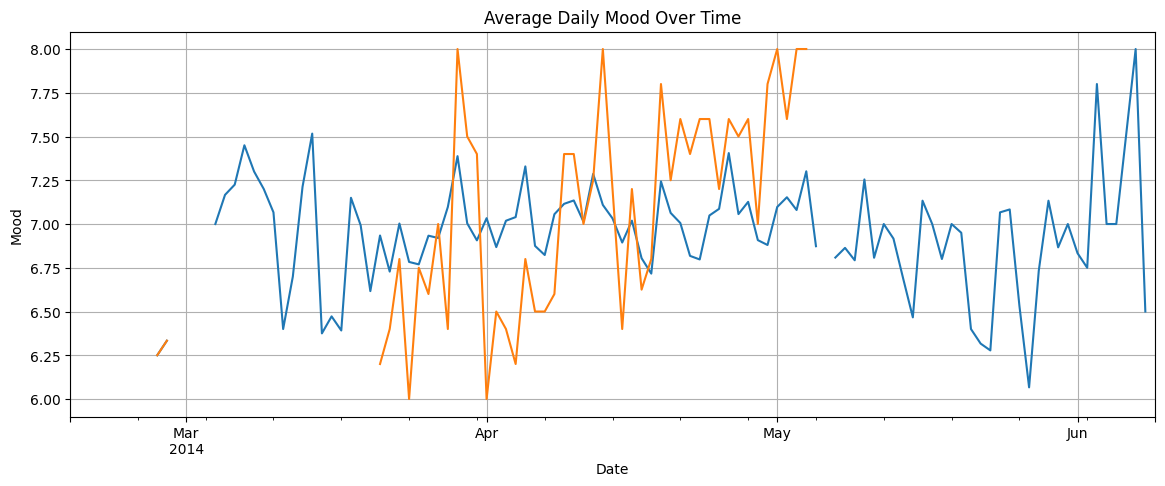

In [5]:
# -*- coding: utf-8 -*-
# mood trend over time
mood_trend = df_daily.groupby('date')['mood'].mean()
plt.figure(figsize=(14, 5))
mood_trend.plot()
df_daily[df_daily['id'] == 'AS14.01'].set_index('date')['mood'].plot()
plt.title("Average Daily Mood Over Time")
plt.ylabel("Mood")
plt.xlabel("Date")
plt.grid(True)
plt.show()

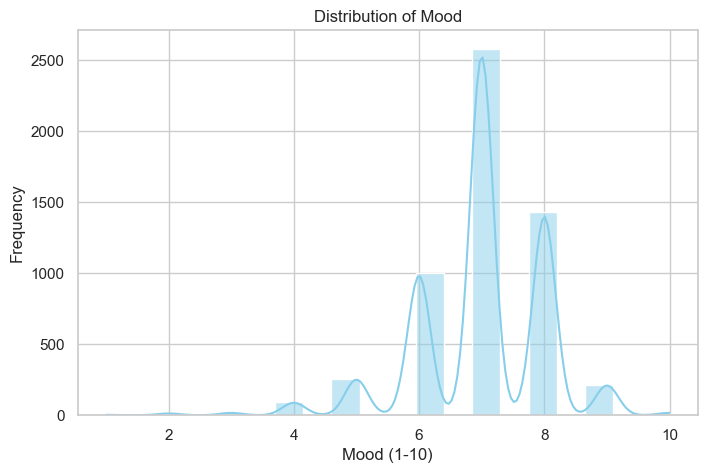

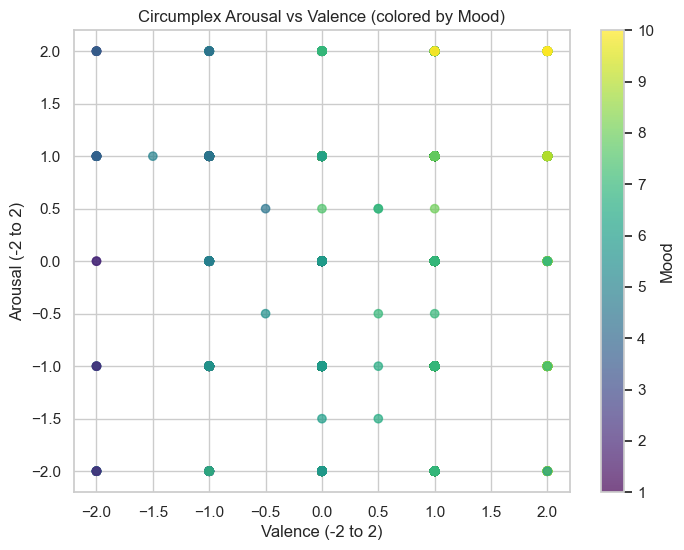

C:\Users\alex\AppData\Local\Temp\ipykernel_36592\3799844068.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Call (1)', 'SMS (1)'], y=[call_count, sms_count], palette="pastel")


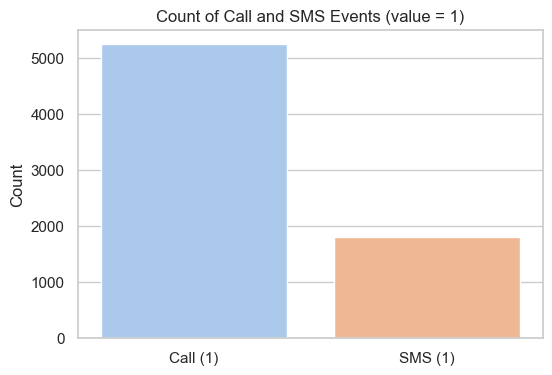

In [6]:
# load the dataset
df = data_load.load_mood_dataset("./raw_data/dataset_mood_smartphone.csv")
sns.set_theme(style="whitegrid")

# 1️⃣ histogram：mood
plt.figure(figsize=(8, 5))
sns.histplot(df['mood'].dropna(), bins=20, kde=True, color='skyblue')
plt.title("Distribution of Mood")
plt.xlabel("Mood (1-10)")
plt.ylabel("Frequency")
plt.show()

# 2️⃣ scatter plot：circumplex arousal vs valence
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df['circumplex.valence'],
    df['circumplex.arousal'],
    c=df['mood'],
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label="Mood")
plt.title("Circumplex Arousal vs Valence (colored by Mood)")
plt.xlabel("Valence (-2 to 2)")
plt.ylabel("Arousal (-2 to 2)")
plt.grid(True)
plt.show()

# 3️⃣ box plot：mood by activity
call_count = df['call'].value_counts().get(1.0, 0)
sms_count = df['sms'].value_counts().get(1.0, 0)

plt.figure(figsize=(6, 4))
sns.barplot(x=['Call (1)', 'SMS (1)'], y=[call_count, sms_count], palette="pastel")
plt.title("Count of Call and SMS Events (value = 1)")
plt.ylabel("Count")
plt.show()


# TASK 1B: DATA CLEANING

## 1B.1 remove outliers

In [14]:
# here is manually defined features to use, from the EDA results above
features_to_use = [
    'screen',
    'activity',
    'appCat.social',
]

optional_features = [
    'call',
    'sms',
    'circumplex.arousal',
    'circumplex.valence',
    'appCat.entertainment',

    'appCat.other',
    'appCat.office',
]

removed_features = [
    # over 99.5% missing values
    'appCat.weather',     
    'appCat.game',   
    'appCat.unknown',
    'appCat.finance',
    # correlated features
    'appCat.entertainment',
    'appCat.communication',
    'appCat.other',
    'appCat.social',
    # optional removed
    'appCat.travel',
    'appCat.utilities',
    'sms',
]

# load the dataset
df = data_load.load_mood_dataset("./raw_data/dataset_mood_smartphone.csv")

# remove high missing values columns
cleaned_df = processing.drop_high_nan_columns(df, threshold=0.995)

# remove correlated features
cleaned_df.drop(columns=removed_features, inplace=True, errors='ignore')
print("cleaned_df data:", cleaned_df.isnull().mean().sort_values(ascending=False))

# aggregate by day
df_daily = processing.aggregate_by_day(cleaned_df)
df_daily.to_csv("./raw_data/cleaned_data_daily_summary.csv", index=False)
print("df_daily data:", df_daily.isnull().mean().sort_values(ascending=False))


删除的列数: 4
被删除的列: ['appCat.finance', 'appCat.game', 'appCat.unknown', 'appCat.weather']
cleaned_df data: variable
call                  0.985404
circumplex.valence    0.984749
circumplex.arousal    0.984448
mood                  0.984320
appCat.office         0.984281
activity              0.936017
appCat.builtin        0.745663
screen                0.730925
time                  0.000000
id                    0.000000
dtype: float64
df_daily data: variable
activity              0.397871
circumplex.valence    0.358338
circumplex.arousal    0.357324
mood                  0.357324
date                  0.000000
id                    0.000000
call                  0.000000
appCat.office         0.000000
appCat.builtin        0.000000
screen                0.000000
dtype: float64


In [2]:
filepath = "./raw_data/cleaned_data_daily_summary.csv"
df_daily = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)

# after aggregation, there are still some missing values
print(f"otally daily items {len(df_daily)} rows")
df_daily = df_daily[df_daily['mood'].notna()].reset_index(drop=True)
print(f"keep mood {len(df_daily)} rows")
df_daily.to_csv("./raw_data/cleaned_data_daily_summary_mood.csv", index=False)

# still some missing values in the dataset, we can use imputation methods to fill them
print("df_daily data:", df_daily.isnull().mean().sort_values(ascending=False))

otally daily items 1973 rows
keep mood 1268 rows
df_daily data: activity              0.093060
circumplex.valence    0.001577
date                  0.000000
id                    0.000000
appCat.office         0.000000
appCat.builtin        0.000000
call                  0.000000
circumplex.arousal    0.000000
mood                  0.000000
screen                0.000000
dtype: float64


## 1B.2 Imputing Missing Values

In [3]:
filepath = "./raw_data/cleaned_data_daily_summary_mood.csv"
df_daily = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)

# impute missing values
df_method1 = imputing.imputing_with_zero(df_daily)
df_method2 = imputing.imputing_with_mean(df_daily)
df_method3 = imputing.imputing_with_removal_NaN(df_daily)
df_method2.to_csv("./raw_data/cleaned_data_daily_summary_mood_imputed.csv", index=False)

print("Method 1 shape:", df_method1.shape)
print("Method 2 shape:", df_method2.shape)
print("Method 3 shape:", df_method3.shape)

Method 1 shape: (1268, 10)
Method 2 shape: (1268, 10)
Method 3 shape: (1254, 10)


d:\code-repo\作业\dmt_assignments\1\src\data\imputing.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_method2[feature_cols] = df_method2.groupby('id')[feature_cols].transform(lambda x: x.fillna(x.mean()))
d:\code-repo\作业\dmt_assignments\1\src\data\imputing.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_method2[feature_cols] = df_method2.groupby('id')[feature_cols].transform(lambda x: x.fillna(x.mean()))
d:\code-repo\作业\dmt_assignments\1\src\data\imputing.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is de

# TASK 1C: FEATURE ENGINEERING

In [4]:
# load the dataset
filepath = "./raw_data/cleaned_data_daily_summary_mood_imputed.csv"
df = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)
df['date'] = pd.to_datetime(df['date'])
df_features = feature_engin.create_sliding_window_dataset(df, window_size=5)

print(df_features.head())
print("after featured:", len(df_features))

df_features.to_csv("./raw_data/cleaned_data_daily_summary_mood_imputed_sliding_window.csv", index=False)


        id       date  mood_target  mood_hist_mean  activity_hist_mean  \
0  AS14.01 2014-03-26          6.6            6.43            0.138201   
1  AS14.01 2014-03-27          7.0            6.51            0.131653   
2  AS14.01 2014-03-28          6.4            6.63            0.116179   
3  AS14.01 2014-03-29          8.0            6.55            0.106770   
4  AS14.01 2014-03-30          7.5            6.95            0.104619   

   appCat.builtin_hist_mean  appCat.office_hist_mean  call_hist_mean  \
0                 1411.3234                  80.7134         5.06250   
1                 1016.9792                  61.4956         4.49375   
2                 1116.5588                  82.7624         4.29375   
3                 2871.8286                  82.7624         4.66250   
4                 3088.9634                  97.3838         3.46250   

   circumplex.arousal_hist_mean  circumplex.valence_hist_mean  \
0                          0.46                      0.54

In [11]:
# -*- coding: utf-8 -*-
import pandas as pd

df1 = pd.read_csv("./raw_data/cleaned_data_daily_summary_mood_imputed.csv")
df2 = pd.read_csv("./raw_data/cleaned_data_daily_summary_mood_imputed_sliding_window.csv")

# add mood_type column
def classify_mood(mood):
    if mood <= 7.0:
        return 0  # down mood
    else:
        return 1  # up mood

df1['mood_type'] = df1['mood'].apply(classify_mood)
df2['mood_type'] = df2['mood_target'].apply(classify_mood)

# save the classified data to CSV files
df1.to_csv("./raw_data/mood_classified.csv", index=False)
df2.to_csv("./raw_data/mood_classified_sliding_window.csv", index=False)

print("✅ Mood classification completed and saved to CSV files.")


✅ Mood classification completed and saved to CSV files.


# TASK 2: CLASSIFICATION

## Task 2A: Random forest

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# === Step 1: load dataset ===
train_df = pd.read_csv("./source_data/train_split_by_id.csv")
test_df = pd.read_csv("./source_data/test_split_by_id.csv")

# === Step 2: define the features cols ===
features = [col for col in train_df.columns if col.endswith('_hist_mean')]
target = 'mood_type'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

print("最佳参数组合：", clf.best_params_)


FileNotFoundError: [Errno 2] No such file or directory: './source_data/train_split_by_id.csv'